In [1]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

from skimage.color import rgb2gray
from skimage.feature import hog

from pathlib import Path
from matplotlib.colors import ListedColormap


### PATHS

In [2]:
PROJ_ROOT = Path().resolve().parents[0]

DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
EXTERNAL_DATA_DIR = DATA_DIR / "external"

MODELS_DIR = PROJ_ROOT / "models/tmp"

In [3]:
input_path: Path = RAW_DATA_DIR / "cifar-10-batches-py"
data_path: Path = EXTERNAL_DATA_DIR / "processed_dataset.pkl"
predictions_path: Path = EXTERNAL_DATA_DIR / "test_predictions.csv"
model_path: Path = MODELS_DIR

### FEATURES AND DATA PROCESSING

In [4]:
def load_data(file_path, encoding=None):
    """
    Load data from a pickle file

    Args:
        file_path: str
    """
    with open(file_path, 'rb') as f:
        if (encoding is not None):
            data = pickle.load(f, encoding=encoding)
        else:
            data = pickle.load(f)
    return data

def save_data(data, file):
    """
    Save data to a pickle file

    Args:
        data: any
        file: str
    """
    with open(file, 'wb') as f:
        pickle.dump(data, f)

def to_image(img_flat):
    """
    Convert a flattened image to a 3D image

    Args:
        img_flat: np.ndarray
    """
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img

def contrast_images(images):
    """
    Compute the contrast of all images

    Args:
        images: np.ndarray
    """
    enhanced_images = []
    for image in images:
        enhanced_images.append(contrast(image))

    return np.array(enhanced_images)

def contrast(image):
    """
    Compute the contrast of an image

    Args:
        image: (32, 32, 3) shape image
    """
    image = image.astype(np.uint8)
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return enhanced_img

def extract_hog_features(images):
    """
    Extract HOG features from a list of images

    Args:
        images: np.ndarray
    """
    hog_features = []

    for image in images:
        gray_image = rgb2gray(image).astype(np.uint8)
        # hog_image_rescaled = exposure.rescale_intensity(gray_image, in_range=(0, 10))
        feature, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None, block_norm='L2-Hys')
        # feature, hog_image = hog(hog_image_rescaled, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None, block_norm='L2-Hys')
        hog_features.append(feature)

    return np.array(hog_features)

def extract_sift_features(images):
    """
    Extract SIFT features from a list of images

    Args:
        images: np.ndarray
    """
    sift = cv2.SIFT_create()
    sift_features = []

    for image in images:
        gray_image = rgb2gray(image).astype(np.uint8)
        # print(image.shape, gray_image.shape, image.dtype, gray_image.dtype)
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)
        if descriptors is None:
            sift_features.append(np.zeros((128,)))
        else:
            sift_features.append(descriptors.flatten())
    
    return np.array(sift_features)

### Image Flattener

In [5]:
class ImageFlattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        x = X.reshape(X.shape[0], -1)
        return x

### MODELS

In [6]:
models = {
    'random_forest': RandomForestClassifier(random_state=42, criterion='entropy', max_depth=10), # criterion, max_depth
    'svm': SVC(max_iter=100 , kernel='rbf', random_state=42), # degree, gamma
    'logistic_regression': LogisticRegression(random_state=42), # penalty, solver
    'knn': KNeighborsClassifier(), # n_neighbors, algorithm
    # 'gradient_boosting': GradientBoostingClassifier(learning_rate=0.01, random_state=42) # loss, max_depth, criterion
}

### PIPELINE

In [7]:
pipeline = Pipeline([
    # ('contrast', FunctionTransformer(contrast_images, validate=False)),
    # ('grayscale', FunctionTransformer(rgb2gray, validate=False)),
    ('flatten', ImageFlattener()),
    # ('scaler', StandardScaler()),
    # ('sift_extraction', FunctionTransformer(extract_sift_features, validate=False)),
    # ('hog_extraction', FunctionTransformer(extract_hog_features, validate=False)),
    # ('vlad', VLAD(k=16, norming="RN", verbose=False)),
    # ('pca', PCA(n_components=2)),
    ('classifier', None)
])

In [8]:
data = load_data(data_path)

train_data = load_data(EXTERNAL_DATA_DIR / "train_data.pkl")

- Version 2D :

/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


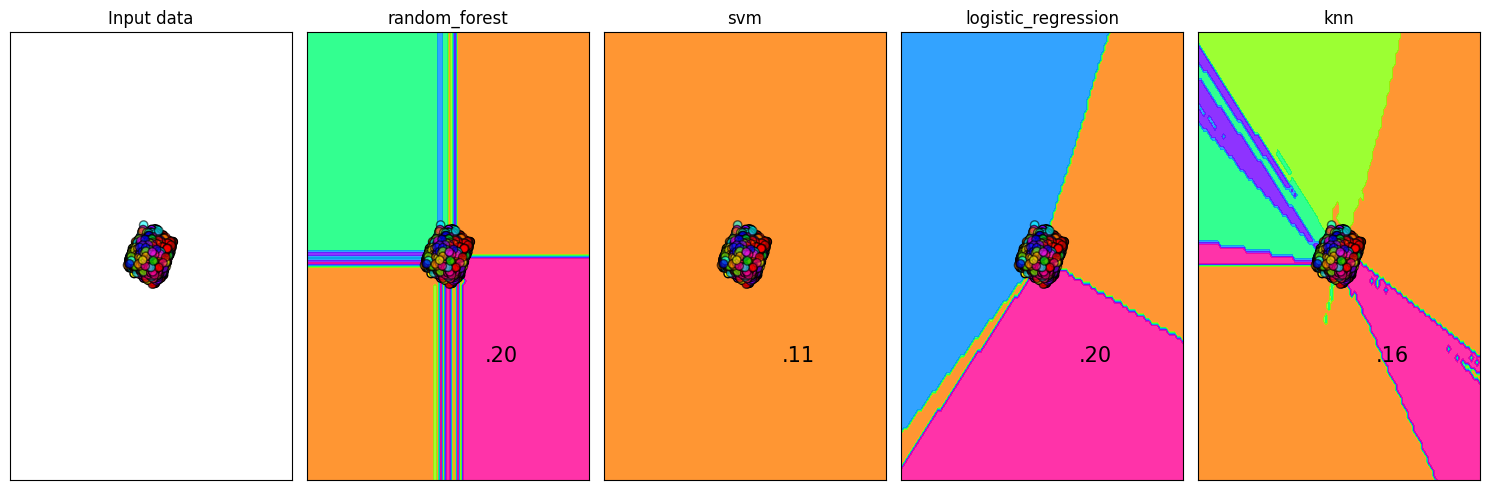

In [9]:
figure = plt.figure(figsize=(15, 5))
i = 1

X, y = train_data[b'data'], train_data[b'labels']
X = X.reshape(-1, 32*32*3) / 255.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

x_min, x_max = X_train_pca[:, 0].min() - 0.5, X_train_pca[:, 0].max() + 0.5
y_min, y_max = X_train_pca[:, 1].min() - 0.5, X_train_pca[:, 1].max() + 0.5

cm = plt.cm.hsv
cm_bright = ListedColormap(['#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF', '#FF00FF', '#FF7F00', '#7FFF00', '#7F00FF', '#FF007F'])
ax = plt.subplot(1, len(models) + 1, i)
ax.set_title("Input data")

ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

for name, model in models.items():
    ax = plt.subplot(1, len(models) + 1, i)
    pipeline.set_params(classifier=model)
    pipeline.fit(X_train_pca, y_train)
    score = pipeline.score(X_test_pca, y_test)
    DecisionBoundaryDisplay.from_estimator(
        pipeline, X_train_pca, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    i += 1

plt.tight_layout()
# plt.savefig("../reports/2D_classifier_comparison.png", bbox_inches='tight')
plt.show()

- Version 3D :

/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


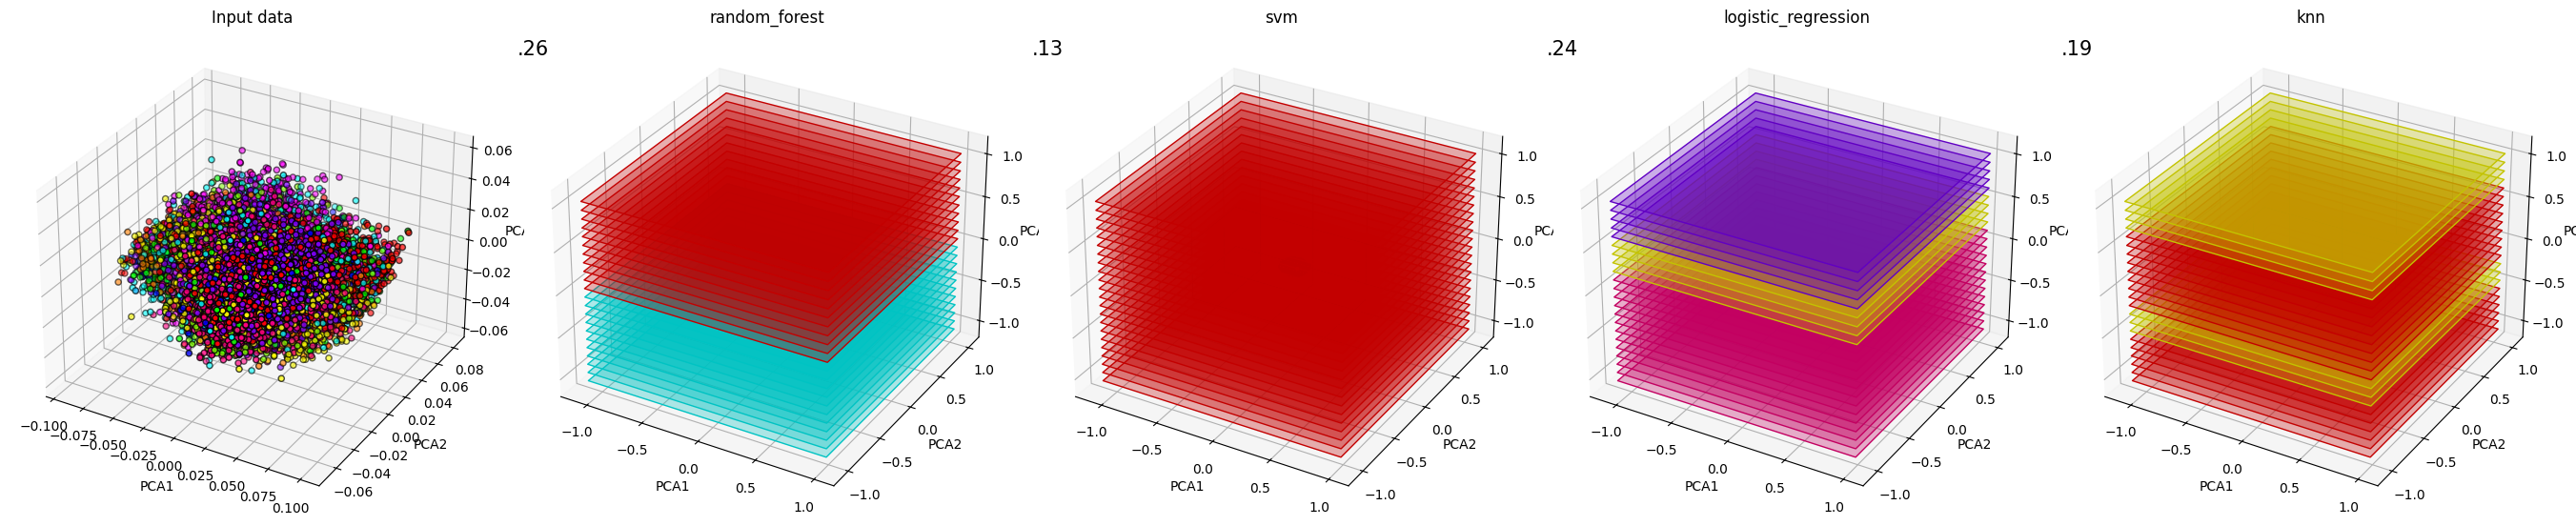

: 

In [10]:
figure = plt.figure(figsize=(27, 9))
i = 1

X, y = train_data[b'data'], train_data[b'labels']
X = X.reshape(-1, 32*32*3) / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# PCA with 3 components for 3D plotting
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Set up 3D plot
ax = figure.add_subplot(1, len(models) + 1, i, projection='3d')
ax.set_title("Input data")

# Colors for 10 classes
cm_bright = ListedColormap(['#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF', '#FF00FF', '#FF7F00', '#7FFF00', '#7F00FF', '#FF007F'])

# Plot training and test points
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap=cm_bright, edgecolors="k")
scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
i += 1

for name, model in models.items():
    ax = figure.add_subplot(1, len(models) + 1, i, projection='3d')

    pipeline.set_params(classifier=model)
    pipeline.fit(X_train_pca, y_train)
    score = pipeline.score(X_test_pca, y_test)

    # Create a mesh grid
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    z_min, z_max = X_train_pca[:, 2].min() - 1, X_train_pca[:, 2].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Predict on the mesh grid
    Z = np.array([pipeline.predict(np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, z)]) for z in np.arange(z_min, z_max, 0.1)])
    
    # Plot decision boundary
    for j, z in enumerate(np.arange(z_min, z_max, 0.1)):
        zz = np.full(xx.shape, z)
        ax.plot_surface(xx, yy, zz, facecolors=cm_bright(Z[j].reshape(xx.shape)), alpha=0.3, rstride=100, cstride=100)

    # Plot training and test points
    scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap=cm_bright, edgecolors="k")
    scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title(name)
    ax.text2D(0.05, 0.95, ("%.2f" % score).lstrip("0"), transform=ax.transAxes, size=15, horizontalalignment="right")
    i += 1

plt.tight_layout()
# plt.savefig("../reports/3D_classifier_comparison.png", bbox_inches='tight')
plt.show()